# Importing the necessary Libraries

In [1]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 273274, done.
remote: Counting objects: 100% (12475/12475), done.
remote: Compressing objects: 100% (597/597), done.
remote: Total 273274 (delta 11896), reused 12404 (delta 11854), pack-reused 260799
Receiving objects: 100% (273274/273274), 548.71 MiB | 35.42 MiB/s, done.
Resolving deltas: 100% (249647/249647), done.
fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [2]:
import torch, torchvision
from torch.utils.data import Dataset, DataLoader

In [3]:
import numpy as np 
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ast 
from PIL import Image
import os 

# Data Preprocessing

In [4]:
path = Path('/kaggle/input/global-wheat-detection')

In [5]:
df = pd.read_csv(path/'train.csv')
df.shape

(147793, 5)

In [6]:
df.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [7]:
cvt2list = lambda x: ast.literal_eval(x) 
df['bbox'] = df['bbox'].apply(cvt2list)

In [8]:
conv = lambda x: [x[0], x[1], x[0]+x[2], x[1]+x[3]]
df['bbox'] = df['bbox'].apply(conv)

In [9]:
df.head()

image_id  width  height                          bbox   source
0  b6ab77fd7   1024    1024  [834.0, 222.0, 890.0, 258.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 356.0, 606.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 451.0, 664.0]  usask_1
3  b6ab77fd7   1024    1024   [834.0, 95.0, 943.0, 202.0]  usask_1
4  b6ab77fd7   1024    1024   [26.0, 144.0, 150.0, 261.0]  usask_1

**Unique Images**

In [10]:
df_processed= df.groupby('image_id')['bbox'].apply(list).reset_index(name='bboxes')

In [11]:
df_processed.head()

image_id                                             bboxes
0  00333207f  [[0, 654, 37, 765], [0, 817, 135, 915], [0, 19...
1  005b0d8bb  [[765.0, 879.0, 881.0, 958.0], [84.0, 539.0, 2...
2  006a994f7  [[437.0, 988.0, 535.0, 1024.0], [309.0, 527.0,...
3  00764ad5d  [[89.0, 256.0, 202.0, 363.0], [216.0, 282.0, 3...
4  00b5fefed  [[709.0, 97.0, 913.0, 202.0], [775.0, 250.0, 9...

**Splitting the dataset into train and valid set**

In [12]:
from sklearn.model_selection import train_test_split

# Split the data into independent and dependent variables
X = df_processed.drop(columns=['bboxes'])
y = df_processed['bboxes']

# Split the data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the train and validation dataframes
train_df = pd.concat([X_train, y_train], axis=1)
valid_df = pd.concat([X_valid, y_valid], axis=1)
train_df.shape, valid_df.shape

((2698, 2), (675, 2))

In [13]:
# taking a small sample for experiment
train_df = train_df.sample(frac=0.1)
valid_df = valid_df.sample(frac=0.1)
train_df.shape, valid_df.shape

((270, 2), (68, 2))

# Pytorch DataLoader

In [14]:
class WheatDataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.df = df
        self.root = Path(root)
        self.transforms = transform
        self.image_ids = self.df.image_id.unique()
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id, bboxes = self.df.iloc[idx]
        img_path = os.path.join(self.root, img_id+'.jpg')
        img = Image.open(img_path)
        boxes = []
        areas = []
        for bbox in bboxes:
            x0 = bbox[0]
            y0 = bbox[1]
            x1 = bbox[2]
            y1 = bbox[3]
            boxes.append([x0, y0, x1, y1])
            areas.append((x1-x0)*(y1-y0))
            
        boxes = np.array(boxes)
        boxes = torch.tensor(bboxes, dtype=torch.float32)
        areas= torch.tensor(areas)
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        target = {'boxes': boxes, 'labels':torch.ones(len(boxes), dtype=torch.int64), 'image_id':torch.tensor(idx), 'area': areas, 'iscrowd': iscrowd}

        if self.transforms is not None:
            img = self.transforms(img)
            
        return img, target

In [15]:
ds = WheatDataset(train_df, path/'train')

# Visualize a dataset

In [16]:
def plot_bboxes(img, target):
    # Get the image and bounding box information
    image = img
    bboxes = target['boxes']
    category_idx = target['labels']
    category_names = ['0', '1']

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10,10))
    

    # Display the image
    ax.imshow(image)

    # Add a bounding box for each object in the image
    for bbox, idx in zip(bboxes, category_idx):
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
#         ax.text(x, y, category_names[idx], color='w', fontsize=12, bbox=dict(facecolor='r', alpha=0.5))

    plt.show()

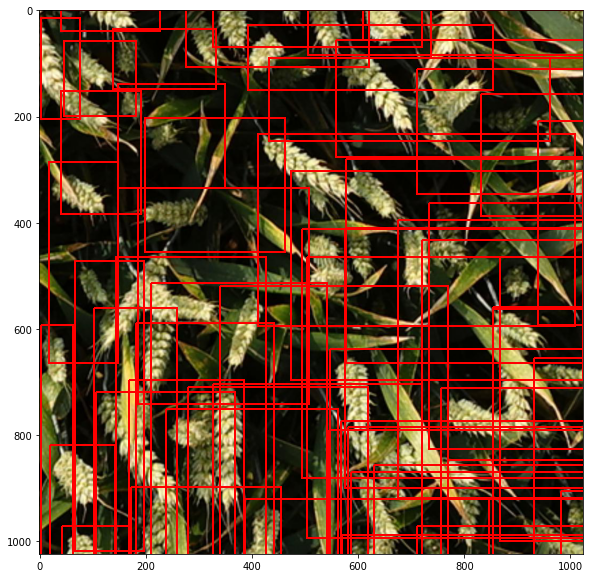

In [17]:
img, target = ds[1]
plot_bboxes(img, target)

**Transform**

In [18]:
import torchvision.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [19]:
train_ds = WheatDataset(train_df, path/'train', transform=get_transform(train=True))
valid_ds = WheatDataset(valid_df, path/'train', transform=get_transform(train=False))

**DataLoader**

In [20]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=8)
valid_dl = DataLoader(valid_ds, collate_fn=collate_fn, batch_size=8)

# Model

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

**Testing on one batch**

In [23]:
images, targets = next(iter(train_dl))

for images, targets in train_dl:

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    loss_dict = model(images, targets)
    print(loss_dict)
    break

{'loss_classifier': tensor(0.5391, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3972, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(4.0669, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.1639, device='cuda:0', grad_fn=<DivBackward0>)}


**Hyperparameter**

In [24]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# Training

In [25]:
import math
import sys
import time

import torch
import torchvision.models.detection.mask_rcnn
import utils
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

#         lr_scheduler = torch.optim.lr_scheduler.linear_lr(
#             optimizer, start_factor=warmup_factor, total_iters=warmup_iters
#         )
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=10
    )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return 

In [26]:
%%time 

# training for 1 epochs
from engine import evaluate
num_epochs = 1

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_dl, device=device)

Epoch: [0]  [ 0/34]  eta: 0:01:19  lr: 0.005000  loss: 5.2069 (5.2069)  loss_classifier: 0.5456 (0.5456)  loss_box_reg: 0.4109 (0.4109)  loss_objectness: 4.1015 (4.1015)  loss_rpn_box_reg: 0.1489 (0.1489)  time: 2.3520  data: 0.3127  max mem: 9753
Epoch: [0]  [10/34]  eta: 0:00:45  lr: 0.000500  loss: 1.7989 (2.0120)  loss_classifier: 0.5248 (0.5026)  loss_box_reg: 0.6150 (0.5719)  loss_objectness: 0.4597 (0.8001)  loss_rpn_box_reg: 0.1433 (0.1374)  time: 1.8844  data: 0.3045  max mem: 10023
Epoch: [0]  [20/34]  eta: 0:00:26  lr: 0.000050  loss: 1.7078 (1.8591)  loss_classifier: 0.4917 (0.4983)  loss_box_reg: 0.6357 (0.6177)  loss_objectness: 0.3967 (0.6076)  loss_rpn_box_reg: 0.1320 (0.1355)  time: 1.8563  data: 0.3038  max mem: 10023
Epoch: [0]  [30/34]  eta: 0:00:07  lr: 0.000005  loss: 1.6777 (1.7978)  loss_classifier: 0.4945 (0.4997)  loss_box_reg: 0.6506 (0.6214)  loss_objectness: 0.3965 (0.5407)  loss_rpn_box_reg: 0.1320 (0.1360)  time: 1.8815  data: 0.2899  max mem: 10023
Epoch

In [27]:
# Saving the model
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

In [28]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return T.ToPILImage()(img).convert('RGB')


# Testing on one image

In [29]:
# pick one image from the test set
img, target = valid_ds[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
# print('real #boxes: ', len(target['labels']))

predicted #boxes:  100


EXPECTED OUTPUT


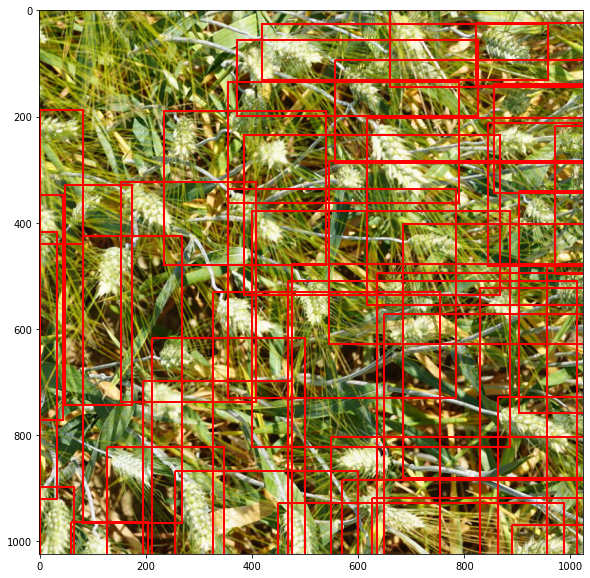

In [30]:
print('EXPECTED OUTPUT')
x, y = valid_ds[5]
x = torch_to_pil(x)
plot_bboxes(x, y)

In [31]:
def plot_bboxes(img, target):
    # Get the image and bounding box information
    image = img
    bboxes = target['boxes'].cpu()
    category_idx = target['labels'].cpu()
    category_names = ['0', '1']

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10,10))
    

    # Display the image
    ax.imshow(image)

    # Add a bounding box for each object in the image
    for bbox, idx in zip(bboxes, category_idx):
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
#         ax.text(x, y, category_names[idx], color='w', fontsize=12, bbox=dict(facecolor='r', alpha=0.5))

    plt.show()

MODEL OUTPUT


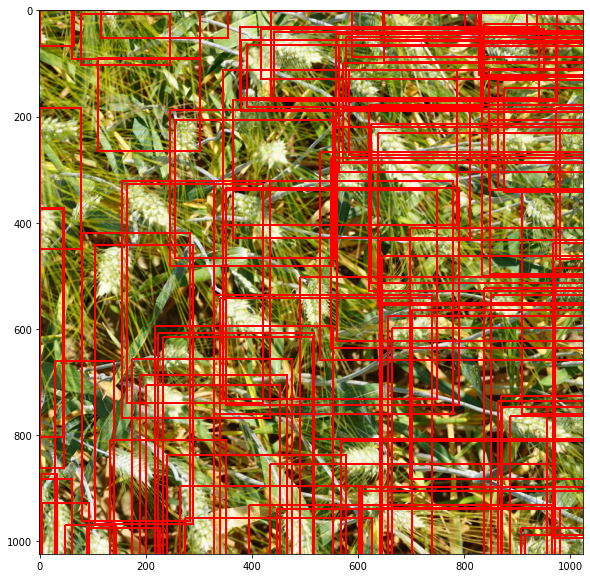

In [32]:
print('MODEL OUTPUT')

plot_bboxes(torch_to_pil(img), prediction)

NMS APPLIED MODEL OUTPUT


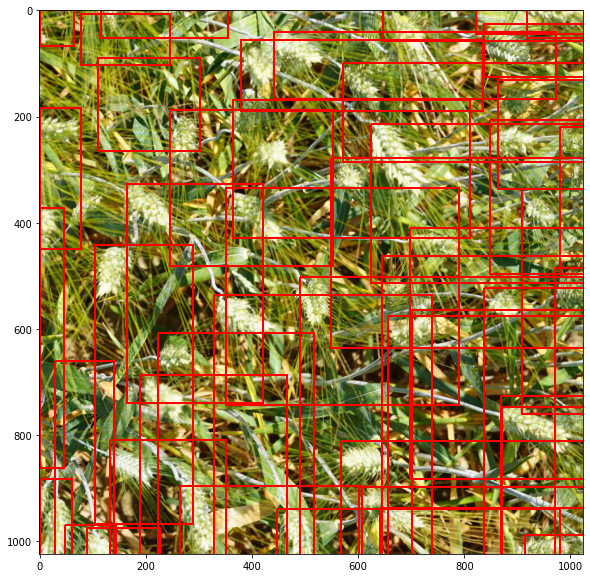

In [33]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_bboxes(torch_to_pil(img), nms_prediction)

# Prediction on test set

In [34]:
test_df = pd.read_csv('/kaggle/input/global-wheat-detection/sample_submission.csv')
test_df.head()

image_id PredictionString
0  aac893a91    1.0 0 0 50 50
1  51f1be19e    1.0 0 0 50 50
2  f5a1f0358    1.0 0 0 50 50
3  796707dd7    1.0 0 0 50 50
4  51b3e36ab    1.0 0 0 50 50

In [35]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [36]:
# Albumentations
import albumentations as A
import cv2
from albumentations.pytorch.transforms import ToTensorV2
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

In [37]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

In [38]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load("fasterrcnn_resnet50_fpn.pth"))
model.eval()

x = model.to(device)

In [39]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, path/'test', get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [40]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [41]:
detection_threshold = 0.2
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)

In [42]:
results[0:2]

[{'image_id': 'aac893a91',
  'PredictionString': '0.4863 301 0 72 54 0.4586 621 912 63 111 0.4466 75 5 87 92 0.4459 572 112 85 84 0.4276 304 849 84 87 0.4253 458 855 82 77 0.4170 259 837 89 88 0.4151 638 0 116 114 0.4132 663 0 83 57 0.4131 806 0 128 50 0.4119 255 837 137 117 0.4041 366 524 82 79 0.3990 172 572 78 86 0.3888 600 762 72 120 0.3879 467 862 51 53 0.3857 199 640 85 90 0.3839 44 0 128 127 0.3783 174 568 105 177 0.3727 375 306 89 90 0.3717 819 986 70 33 0.3692 561 80 84 88 0.3680 178 341 73 62 0.3660 225 808 130 124 0.3657 735 768 84 87 0.3654 329 656 84 84 0.3585 627 923 52 56 0.3569 591 886 125 131 0.3554 37 458 83 89 0.3524 99 60 78 86 0.3505 606 165 78 80 0.3473 44 0 122 51 0.3441 587 129 87 88 0.3440 610 802 81 91 0.3416 594 604 83 87 0.3384 469 1 126 62 0.3369 561 59 107 180 0.3344 568 542 85 84 0.3341 367 729 81 80 0.3329 449 696 87 86 0.3307 183 583 47 55 0.3238 189 592 72 124 0.3228 240 83 85 80 0.3221 504 0 113 50 0.3216 0 0 53 55 0.3166 809 2 92 30 0.3164 283 134 81

In [43]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

image_id                                   PredictionString
0  aac893a91  0.4863 301 0 72 54 0.4586 621 912 63 111 0.446...
1  51f1be19e  0.4064 766 890 87 90 0.3822 507 497 84 87 0.37...
2  f5a1f0358  0.4181 552 412 78 92 0.3973 611 717 85 84 0.39...
3  796707dd7  0.4308 0 446 68 76 0.4307 898 335 86 86 0.3719...
4  51b3e36ab  0.4834 871 190 124 69 0.4711 367 151 89 90 0.4...

In [44]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

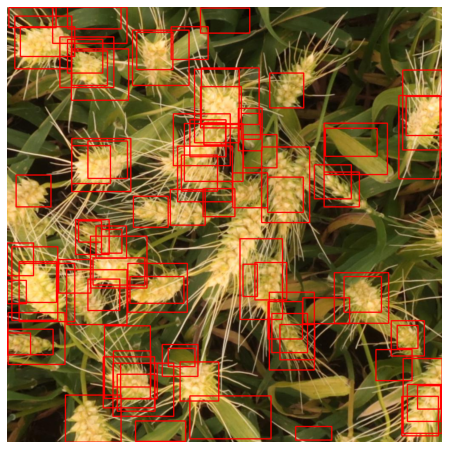

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [46]:
test_df.to_csv('submission.csv', index=False)